In [1]:
#Load libraries

import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
#print('done')

In [2]:
#Load wine dataset

df = pd.read_csv('D:/SDU/thesisCodes/data/datasets_4458_8204_winequality-red.csv') # Load the data

# Create Classification version of target variable
df['goodquality'] = [1 if x >= 7 else 0 for x in df['quality']]
# Separate feature variables and target variable
X = df.drop(['quality','goodquality'], axis = 1)
Y = df['goodquality']

# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

#print(X)
#print(Y)

In [3]:
#Build the random forest classifier
rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [4]:
yPredRf = rf.predict(X_test)

In [5]:
print(metrics.classification_report(Y_test, yPredRf))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       290
           1       0.54      0.47      0.50        30

    accuracy                           0.91       320
   macro avg       0.74      0.71      0.73       320
weighted avg       0.91      0.91      0.91       320



Text(0, 0.5, 'Cross-validated accuracy')

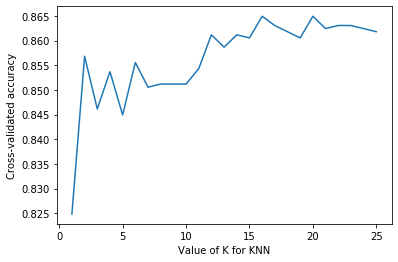

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# Number of k from 1 to 26
k_range = range(1, 26)
k_scores = []
# Calculate cross validation score for every k number from 1 to 26
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # It’s 10 fold cross validation with ‘accuracy’ scoring 
    scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())
    
%matplotlib inline
# Plot accuracy for every k number between 1 and 26
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [7]:
# Train the model and predict for k=16
knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, Y_train)
yPredKNN = knn.predict(X_test)

# classification report for test set
print(metrics.classification_report(Y_test, yPredKNN))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       290
           1       0.75      0.10      0.18        30

    accuracy                           0.91       320
   macro avg       0.83      0.55      0.57       320
weighted avg       0.90      0.91      0.88       320



In [8]:
gnb=GaussianNB()
gnb.fit(X_train,Y_train)

yPredGNB = gnb.predict(X_test)


# classification report for test set
print(metrics.classification_report(Y_test, yPredGNB))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90       290
           1       0.32      0.77      0.45        30

    accuracy                           0.82       320
   macro avg       0.65      0.80      0.67       320
weighted avg       0.91      0.82      0.85       320



In [9]:
xgbModel = xgb.XGBClassifier(random_state=1)
xgbModel.fit(X_train, Y_train)
yPredXGB = xgbModel.predict(X_test)
print(metrics.classification_report(Y_test, yPredXGB))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       290
           1       0.53      0.77      0.63        30

    accuracy                           0.92       320
   macro avg       0.75      0.85      0.79       320
weighted avg       0.93      0.92      0.92       320



In [10]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, Y_train)

yPredSVM = svclassifier.predict(X_test)
print(metrics.classification_report(Y_test, yPredSVM))

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.


              precision    recall  f1-score   support

           0       0.93      0.98      0.95       290
           1       0.57      0.27      0.36        30

    accuracy                           0.91       320
   macro avg       0.75      0.62      0.66       320
weighted avg       0.89      0.91      0.90       320



In [11]:
#Prepare Y_test for Manifold
Y_testMf = Y_test.to_frame()
Y_testMf = Y_testMf.replace(0, 'False')
Y_testMf = Y_testMf.replace(1, 'True')
Y_testMf = Y_testMf.values.tolist()

Y_testMfFlat = []
for sublist in Y_testMf:
    for item in sublist:
        Y_testMfFlat.append(item)

In [12]:
#Prepare RF dataset for Manifold
yPredRFpp = rf.predict_proba(X_test)

yPredRFpp0 = yPredRFpp[:,0]
yPredRFpp1 = yPredRFpp[:,1]

yPredRFpp0 = yPredRFpp0.tolist()
yPredRFpp1 = yPredRFpp1.tolist()

yPredRFppFinal = [{'True': f, 'False': c} for f, c in zip(yPredRFpp1, yPredRFpp0)]


#Prepare GNB dataset for Manifold
yPredGNBpp = gnb.predict_proba(X_test)

yPredGNBpp0 = yPredGNBpp[:,0]
yPredGNBpp1 = yPredGNBpp[:,1]

yPredGNBpp0 = yPredGNBpp0.tolist()
yPredGNBpp1 = yPredGNBpp1.tolist()

yPredGNBppFinal = [{'True': f, 'False': c} for f, c in zip(yPredGNBpp1, yPredGNBpp0)]


#Prepare KNN dataset for Manifold
yPredKNNpp = knn.predict_proba(X_test)

yPredKNNpp0 = yPredKNNpp[:,0]
yPredKNNpp1 = yPredKNNpp[:,1]

yPredKNNpp0 = yPredKNNpp0.tolist()
yPredKNNpp1 = yPredKNNpp1.tolist()

yPredKNNppFinal = [{'True': f, 'False': c} for f, c in zip(yPredKNNpp1, yPredKNNpp0)]


#Prepare XGB dataset for Manifold
yPredXGBpp = xgbModel.predict_proba(X_test)
yPredXGBpp = yPredXGBpp.astype(np.float64)

yPredXGBpp0 = yPredXGBpp[:,0]
yPredXGBpp1 = yPredXGBpp[:,1]

yPredXGBpp0 = yPredXGBpp0.tolist()
yPredXGBpp0 = yPredXGBpp1.tolist()

yPredXGBppFinal = [{'True': f, 'False': c} for f, c in zip(yPredXGBpp1, yPredXGBpp0)]


In [13]:
allModels = []
allModels.append(yPredGNBppFinal)
allModels.append(yPredRFppFinal)
allModels.append(yPredKNNppFinal)
allModels.append(yPredXGBppFinal)

In [1]:
from mlvis import Manifold
Manifold(props={'data': {
    'x': X_test,
    'yPred': allModels,
    'yTrue': Y_testMfFlat
}})

NameError: name 'X_test' is not defined

In [16]:
segments = [[7,14,23,52,53,62,67,69,75,82,83,86,88,101,103,107,110,116,128,133,134,136,140,147,148,150,151,152,158,169,170,174,175,184,190,201,211,215,221,223,224,226,227,231,233,236,244,249,254,261,276,278,284,289,292,304,316,2,15,16,20,27,29,34,35,38,39,41,42,43,58,65,68,79,92,94,96,100,108,112,117,118,124,125,129,132,138,146,159,162,167,173,176,177,178,181,183,207,208,213,217,222,232,234,237,238,259,269,274,279,281,288,305,315,317,319],[5,6,8,9,10,11,21,24,25,26,28,36,37,40,45,48,50,56,57,60,64,66,73,74,77,81,87,89,90,91,93,97,104,105,106,111,113,120,122,123,126,130,135,137,141,149,153,155,157,172,179,180,182,185,188,192,194,195,196,200,202,205,209,210,212,214,219,220,228,230,241,243,245,246,247,248,250,251,252,253,256,257,258,260,262,267,277,285,293,296,298,299,301,302,303,306,307,309,313,314,318,0,1,3,4,12,13,17,18,19,22,30,31,32,33,44,46,47,49,51,54,55,59,61,63,70,71,72,76,78,80,84,85,95,98,99,102,109,114,115,119,121,127,131,139,142,143,144,145,154,156,160,161,163,164,165,166,168,171,186,187,189,191,193,197,198,199,203,204,206,216,218,225,229,235,239,240,242,255,263,264,265,266,268,270,271,272,273,275,280,282,283,286,287,290,291,294,295,297,300,308,310,311,312]]

In [26]:
len(segments)
X_test.shape
len(segments[0])

116

In [23]:
for segment in segments:
    for val in segment:
        if val == 319:
            print(val)
        

319


In [32]:
X_test_segment1 = X_test.loc[segments[0]]
X_test_segment2 = X_test.loc[segments[1]]

print(len(X_test_segment1))
print(len(X_test_segment2))

116
204


In [28]:
X_test_segment1

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,8.9,0.620,0.18,3.8,0.176,52.0,145.0,0.99860,3.16,0.88,9.2
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,6.6,0.500,0.04,2.1,0.068,6.0,14.0,0.99550,3.39,0.64,9.4
53,8.6,0.380,0.36,3.0,0.081,30.0,119.0,0.99700,3.20,0.56,9.4
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,7.4,0.500,0.47,2.0,0.086,21.0,73.0,0.99700,3.36,0.57,9.1


In [36]:
X_test_1_summary = shap.kmeans(X_test_segment1, 10)

rf_explainer = shap.TreeExplainer(rf)
rf_shap_values = rf_explainer.shap_values(X_test_segment1)
print("rf")

knn_explainer = shap.KernelExplainer(knn.predict, X_test_1_summary)
knn_shap_values = knn_explainer.shap_values(X_test_segment1)
print("knn")

gnb_explainer = shap.KernelExplainer(gnb.predict, X_test_1_summary)
gnb_shap_values = gnb_explainer.shap_values(X_test_segment1)
print("gnb")

myxgbbooster = xgbModel.get_booster()    
model_bytearray = myxgbbooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
myxgbbooster.save_raw = myfun

xgb_explainer = shap.TreeExplainer(myxgbbooster)
xgb_shap_values = xgb_explainer.shap_values(X_test_segment1)
print("xgb")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


rf


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!



knn


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!



gnb


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 333: invalid start byte

In [38]:
X_test_2_summary = shap.kmeans(X_test_segment2, 10)

rf_shap_values2 = rf_explainer.shap_values(X_test_segment2)
print("rf")

knn_explainer2 = shap.KernelExplainer(knn.predict, X_test_2_summary)
knn_shap_values2 = knn_explainer2.shap_values(X_test_segment2)
print("knn")

gnb_explainer2 = shap.KernelExplainer(gnb.predict, X_test_2_summary)
gnb_shap_values2 = gnb_explainer2.shap_values(X_test_segment2)
print("gnb")

xgb_shap_values2 = xgb_explainer.shap_values(X_test_segment2)
print("xgb")

rf


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


knn


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


gnb
xgb


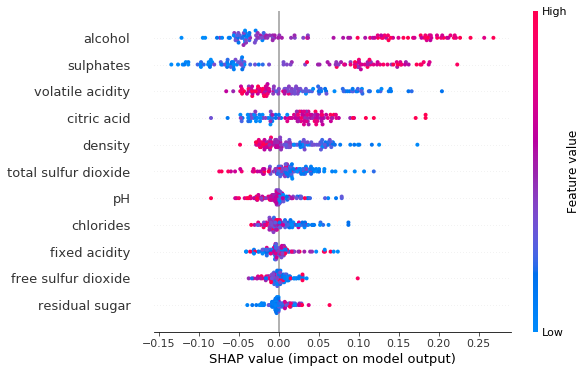

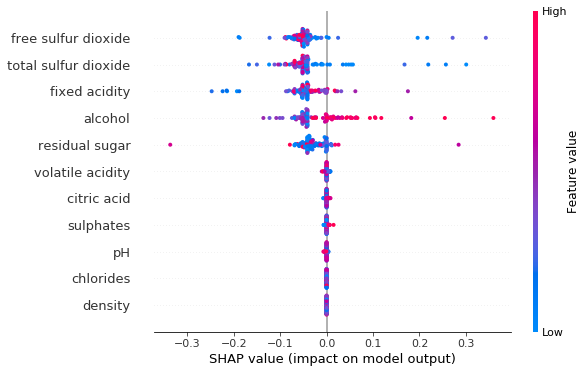

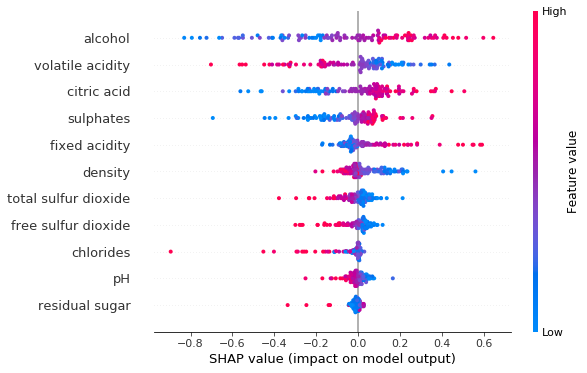

IndexError: index 121 is out of bounds for axis 0 with size 116

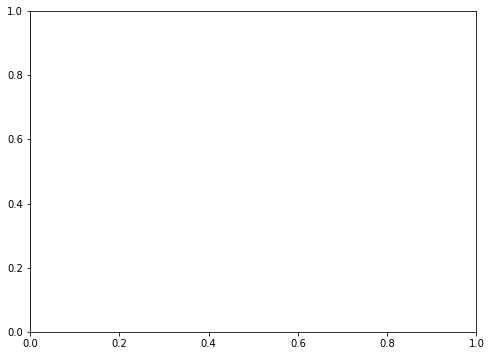

In [41]:
shap.summary_plot(rf_shap_values[1], X_test_segment1)
shap.summary_plot(knn_shap_values, X_test_segment1)
shap.summary_plot(gnb_shap_values, X_test_segment1)
shap.summary_plot(xgb_shap_values, X_test_segment1)

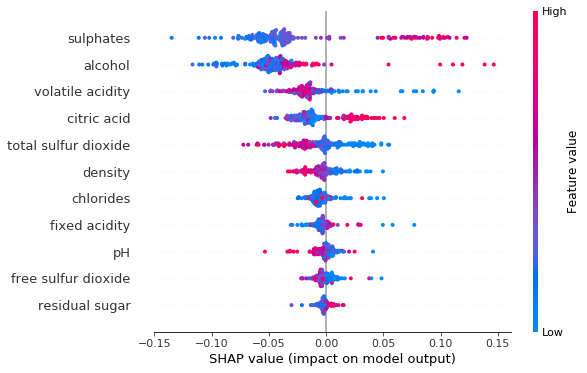

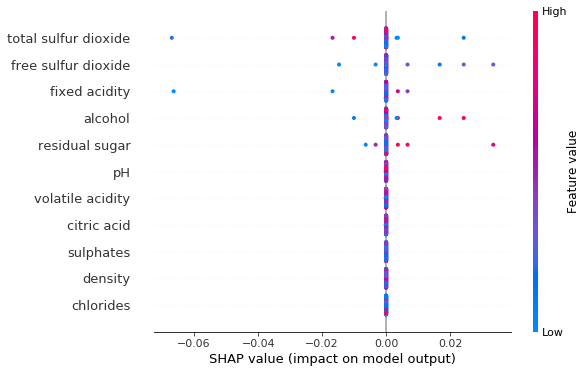

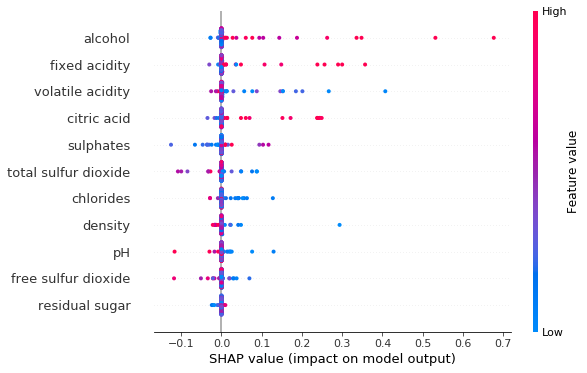

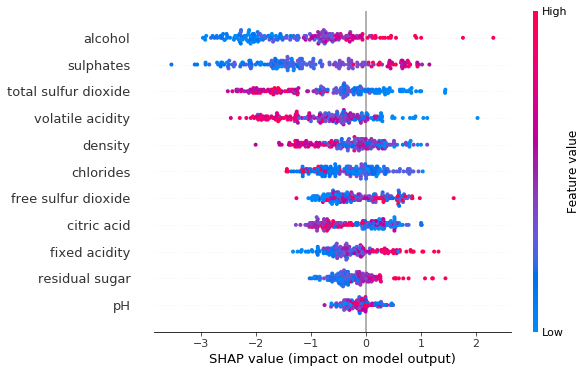

In [40]:
shap.summary_plot(rf_shap_values2[1], X_test_segment2)
shap.summary_plot(knn_shap_values2, X_test_segment2)
shap.summary_plot(gnb_shap_values2, X_test_segment2)
shap.summary_plot(xgb_shap_values2, X_test_segment2)